## Distributed lag model

$$
y_{t}=a+w_{0}x_{t}+w_{1}x_{t-1}+w_{2}x_{t-2}+...+{\text{error term}}
$$

https://en.wikipedia.org/wiki/Distributed_lag

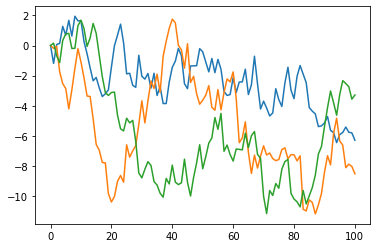

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
time = np.arange(N+1)
dt = 1
d = 3

x_diff = np.random.normal(size = [N,d]) * np.sqrt(dt)
x = np.cumsum(x_diff,axis = 0)
x = np.concatenate([np.zeros([1,d]), x], axis = 0)

# x1 = 0.5 * np.sqrt(time)[:,None]
# x2 = np.sin(time)[:,None]
# x3 = np.log(time+1)[:,None]
# x = np.concatenate([x1,x2,x3], axis = 1)

plt.plot(time,x)
plt.show()

In [2]:
def lag(x,order):
    x = x[:,None,:]
    X = x[order:]
    for i in range(1,order+1):
        helper = x[order-i:-i]
        X = np.concatenate([helper,X], axis = 1)
    return X

x_lag = lag(x,3)
len_lag = x_lag.shape[0]

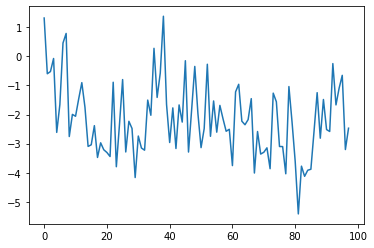

In [3]:
import torch
import torch.nn as nn
x_lag_flatten = torch.tensor(x_lag, dtype = torch.float).view([len_lag,-1])
linear = nn.Linear(x_lag_flatten.shape[-1],1)
y = linear(x_lag_flatten)
y = y.detach().numpy() + np.random.normal(size = [len_lag,1])
plt.plot(y)
plt.show()

In [4]:
import sklearn
split = 60
num_sample = x_lag.shape[0]
X = np.reshape(x_lag,[num_sample,-1])
y = y
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [5]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)
y_predict = np.concatenate([y_train_predict,y_test_predict],axis = 0)

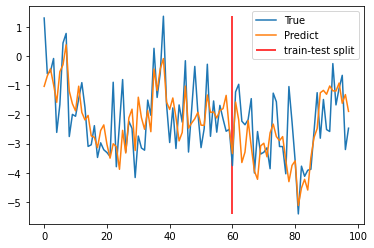

In [6]:
plt.plot(y)
plt.plot(y_predict)
lmax = max(y.max(),y_predict.max())
lmin = min(y.min(),y_predict.min())
plt.vlines(split,lmin,lmax,'r')
plt.legend(['True', 'Predict', 'train-test split'])
plt.show()

## Real Data

In [218]:
import pandas as pd
from sklearn import preprocessing
df = pd.read_csv("data/1_owid/owid-covid-data.csv")

In [220]:
df0 = df[df['continent'] == 'Europe']
df0 = df0[['date',\
           'location',\
       'new_cases_smoothed_per_million',\
       'new_deaths_smoothed_per_million',\
       'icu_patients_per_million',\
       'positive_rate']]
df0 =df0.dropna()
C = list(df0['location'].drop_duplicates())
df00 = df0.drop(columns=['date','location'])
x = df00.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df00 = pd.DataFrame(x_scaled, index = df00.index, columns=df00.columns)


Austria


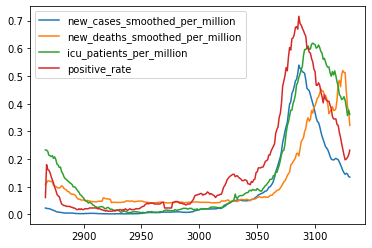

Belgium


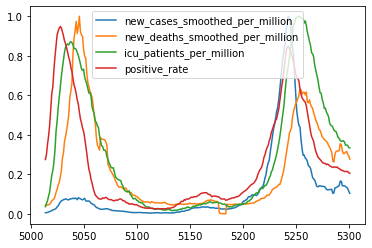

Cyprus


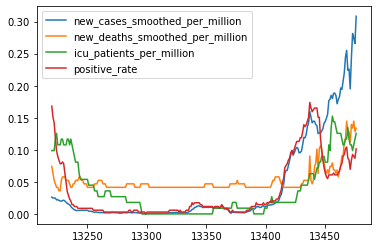

Czechia


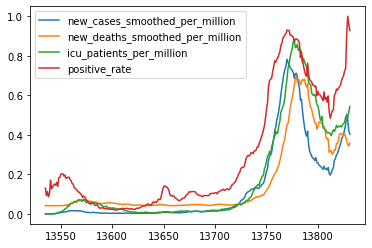

Denmark


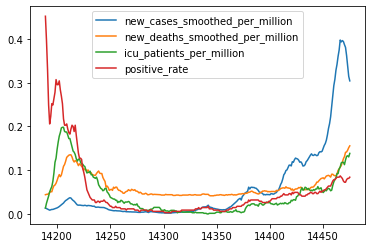

Estonia


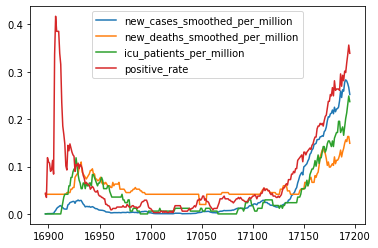

Finland


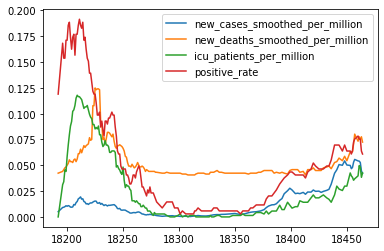

France


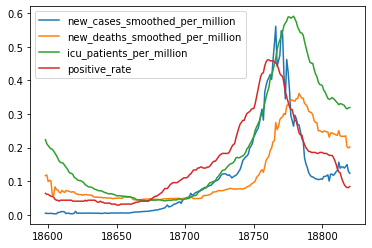

Germany


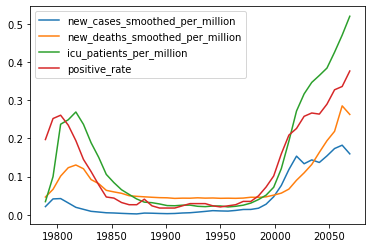

Iceland


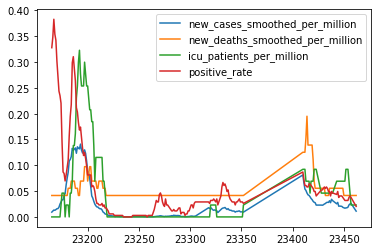

Ireland


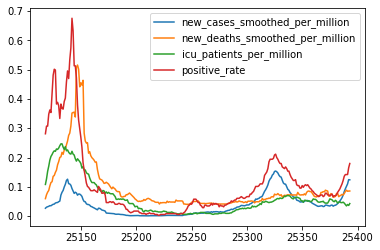

Italy


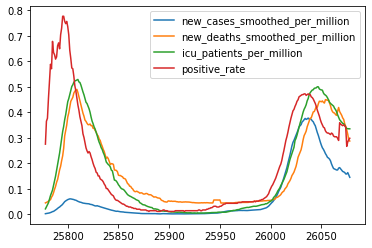

Luxembourg


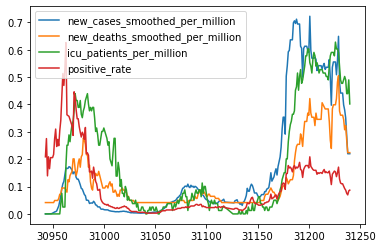

Malta


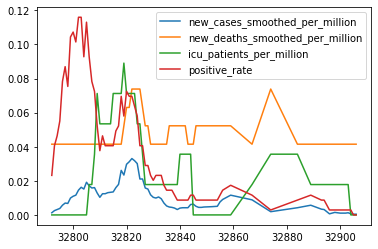

Netherlands


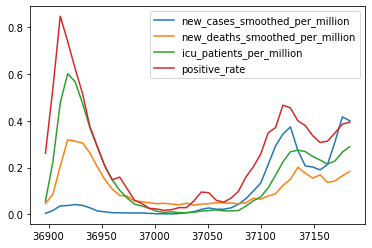

Portugal


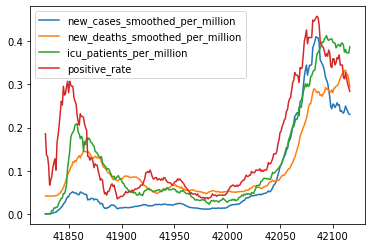

Romania


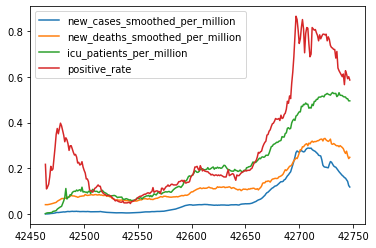

Slovenia


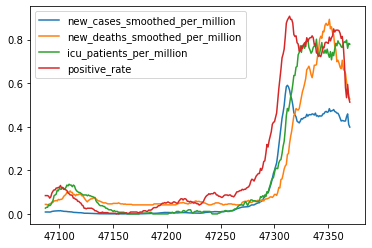

Spain


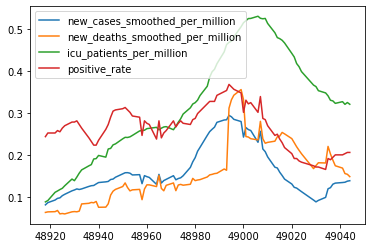

Sweden


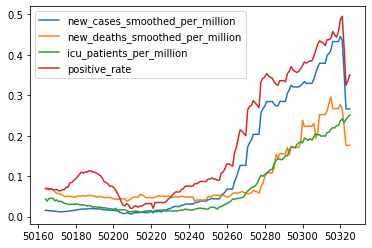

United Kingdom


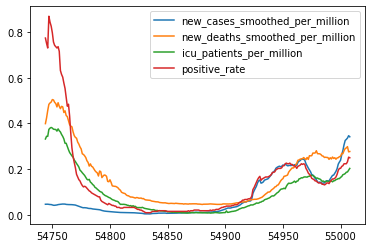

In [223]:
for c in C:
    print(c)
    cc = df00[df0['location'] == c]
    cc.plot()
    plt.show()

In [ ]:
df = pd.read_csv("data/1_owid/owid-covid-data.csv")